In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.losses import mse, binary_crossentropy
from keras import optimizers

import numpy as np

In [6]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
def create_encoder(input_shape, latent_shape, hidden_shapes = [], variational = False):
    layers = list()
    # add input
    layers.append(Input(shape = (input_shape,), name = 'encoder_input'))
    # add hidden layers
    for index, hidden_shape in enumerate(hidden_shapes):
        layers.append(Dense(hidden_shape, activation = 'relu', name = 'encoder_hidden_' + str(index+1))(layers[-1]))
    # add output
    if(variational):
        latent_mean = Dense(latent_shape, name = 'encoder_latent_mean')(layers[-1])
        latent_log_var = Dense(latent_shape, name = 'encoder_latent_log_var')(layers[-1])
        latent_sample = Lambda(sampling, output_shape=(latent_shape,), name='encoder_latent')([latent_mean, latent_log_var])
        layers.append([latent_mean, latent_log_var, latent_sample])
    else:
        layers.append(Dense(latent_shape, activation = 'sigmoid', name = 'encoder_latent')(layers[-1]))
    # create model
    encoder = Model(inputs = layers[0], outputs = layers[-1], name = 'encoder')
    return encoder

In [8]:
def create_decoder(latent_shape, output_shape, hidden_shapes = []):
    layers = list()
    # add input
    layers.append(Input(shape = (latent_shape,), name = 'decoder_input'))
    # add hidden layers
    for index, hidden_shape in enumerate(hidden_shapes):
        layers.append(Dense(hidden_shape, activation = 'relu', name = 'decoder_hidden_' + str(index+1))(layers[-1]))
    # add output
    layers.append(Dense(output_shape, activation = 'sigmoid', name = 'decoder_output')(layers[-1]))
    # create model
    decoder = Model(inputs = layers[0], outputs = layers[-1], name = 'decoder')
    return decoder

In [9]:
def create_autoencoder(input_shape, latent_shape, hidden_shapes = [], variational = False):
    encoder = create_encoder(input_shape, latent_shape, hidden_shapes, variational)
    decoder = create_decoder(latent_shape, input_shape, list(reversed(hidden_shapes)))
    
    inputs = encoder.input
    latent = encoder.output
    outputs = None
    if(variational):
        outputs = decoder(encoder(inputs)[2])
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= np.prod(input_shape)
        kullback_leibler_loss = 1 + latent[1] - K.square(latent[0]) - K.exp(latent[1])
        kullback_leibler_loss = K.sum(kullback_leibler_loss, axis=-1)
        kullback_leibler_loss *= -0.5
        loss = K.mean(reconstruction_loss + kullback_leibler_loss)
    else:
        outputs = decoder(encoder(inputs))
        loss = binary_crossentropy(inputs, outputs)
        
    autoencoder = Model(encoder.get_input_at(0), outputs, name = 'autoencoder')
    autoencoder.add_loss(loss)
    autoencoder.compile(optimizer='adam')
    
    return autoencoder

In [15]:
from mnist import MNIST

mndata = MNIST('mnist_data')

def convert_for_nn(images, labels):
    '''
    for i in range(len(images)):
        images[i] = np.asarray(images[i]).reshape((28, 28))
    '''
    return np.asarray(images), np.asarray(labels)

train_images, train_labels = mndata.load_training()
train_images, train_labels = convert_for_nn(train_images, train_labels)
test_images, test_labels = mndata.load_testing()
test_images, test_labels = convert_for_nn(test_images, test_labels)

train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

ImportError: cannot import name 'MNIST'

In [457]:
autoencoder = create_autoencoder(784, 100, [512], variational=False)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 100)               453220    
_________________________________________________________________
decoder (Model)              (None, 784)               453904    
Total params: 907,124
Trainable params: 907,124
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


In [458]:
history = autoencoder.fit(train_images, epochs=5, batch_size=200, validation_data=(test_images, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 151us/step - loss: 0.2319 - val_loss: 0.1751
Epoch 2/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.1547 - val_loss: 0.1366
Epoch 3/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.1281 - val_loss: 0.1186
Epoch 4/5
60000/60000 [==============================] - 8s 137us/step - loss: 0.1130 - val_loss: 0.1067
Epoch 5/5
60000/60000 [==============================] - 8s 139us/step - loss: 0.1040 - val_loss: 0.0993


In [459]:
from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline

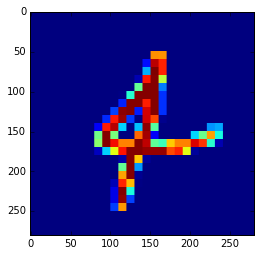

In [481]:
image_array = test_images[300]
imshow(Image.fromarray((image_array.reshape((28,28)) * 255).astype(np.uint8), 'L').resize((280,280)))

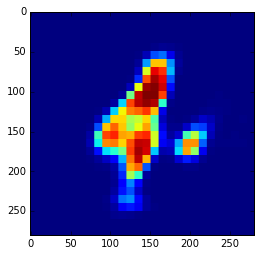

In [482]:
image_array = autoencoder.predict(test_images[300][None,:])[0]
imshow(Image.fromarray((image_array.reshape((28,28)) * 255).astype(np.uint8), 'L').resize((280,280)))

In [455]:
autoencoder.layers[1].predict(test_images[800][None,:])[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

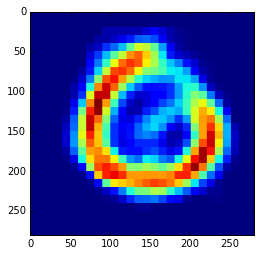

In [421]:
image_array = autoencoder.layers[2].predict(np.array([-2, 1])[None,:])
imshow(Image.fromarray((image_array.reshape((28,28)) * 255).astype(np.uint8), 'L').resize((280,280)))

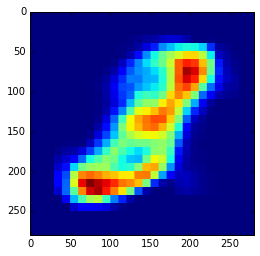

In [375]:
image_array = autoencoder.layers[2].predict(np.array([1, -1, 1, .5])[None,:])
imshow(Image.fromarray((image_array.reshape((28,28)) * 255).astype(np.uint8), 'L').resize((280,280)))